In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import folium

# Process Ripple Topology

## Load data

In [2]:
nodes_ripple = pd.read_csv('ripple-asn-nodes.csv', delimiter=',', header=None, names=['asn','lat','lon']).dropna().drop_duplicates()
links_ripple = pd.read_csv('ripple-asn-links.csv', delimiter=',', header=None, names=['start','end']).dropna().drop_duplicates()

In [3]:
list_double = set()
def remove_double_asn(x):
    if(' ' in x):
        list_double.add(tuple(x.split(' ')))
        return x.split(' ')[0]
    else:
        return x

In [4]:
nodes_ripple['asn'] = nodes_ripple['asn'].apply(lambda x: remove_double_asn(x))
links_ripple['start'] = links_ripple['start'].apply(lambda x: remove_double_asn(x))
links_ripple['end'] = links_ripple['end'].apply(lambda x: remove_double_asn(x))

In [5]:
links_ripple = links_ripple[~(links_ripple['start'] == links_ripple['end'])]

#### Is there any problem to consider one AS when a node has multiple AS number?

Let's check the connectivity. If there is a link between these nodes, the node remains connected.

In [6]:
list_double

{('16509', '38895'), ('23724', '133119'), ('4808', '23724')}

('23724', '133119') and ('4808', '23724') are connected because they share a common AS

Is there any link between 16509 and 23724?

In [7]:
links_ripple[(links_ripple['start'] == '16509') & (links_ripple['end'] == '23724')]

start    end
7367   16509  23724
10894  16509  23724

Yes, so we can assume that removing one AS does not break the network

## Add latitude/longitude for each AS

In [8]:
temp = nodes_ripple[['asn','lat','lon']].set_index('asn')
temp.columns = temp.columns.get_level_values(0)

temp['pos'] = list(zip(temp.lat, temp.lon))

ases_ripple = temp['pos'].to_dict()

# Process Caida Topology

## Load data

In [9]:
data = pd.read_csv('../Caida/20190301.as-rel2.txt',delimiter='\n', comment='#', header=None, encoding='ISO-8859-1')

## Extract nodes and links 

In [10]:
data['provider_peer'], data['customer_peer'], data['relation_type'], data['source'] = data[0].str.split('|').str
data['relation_type']  = data['relation_type'].apply(lambda x: 'provider-customer' if x == '-1' else 'peer-peer')
links_caida = data[['provider_peer','customer_peer','relation_type']]

In [11]:
ases_caida = set(links_caida['provider_peer'].values)
ases_caida.update(links_caida['customer_peer'].values)

## Do all the ripple ases are in caida ases?

In [12]:
counter = 0
for elem in ases_ripple.keys():
    if elem not in ases_caida:
        counter += 1
counter

0

## Do all the ripple links are in caida links?

In [13]:
ripple_l = list(zip(links_ripple.start, links_ripple.end))
caida_l = list(zip(links_caida.provider_peer, links_caida.customer_peer))
counter = 0
for elem in ripple_l:
    if elem not in caida_l:
        if tuple(reversed(elem)) not in caida_l:
            counter += 1
counter

1028

As we can see most of the ripple links are not present in the caida dataset. What does it mean? It means that two ripple ases are not directly linked.

# Computation of shortest paths

In [14]:
def find_customers(source, links):
    neighbors = links[links['provider_peer'] == source][['customer_peer','relation_type']]
    customers = neighbors[neighbors['relation_type'] == 'provider-customer']
    
    return set(customers['customer_peer'].values)

def find_peers(source, links):
    neighbors1 = links[links['provider_peer'] == source][['customer_peer','relation_type']]
    peers1 = neighbors1[neighbors1['relation_type'] == 'peer-peer']
    peers1 = set(peers1['customer_peer'].values)
    
    neighbors2 = links[links['customer_peer'] == source][['provider_peer','relation_type']]
    peers2 = neighbors2[neighbors2['relation_type'] == 'peer-peer']
    peers1.update(peers2['provider_peer'].values)
    
    return peers1

def find_providers(source, links):
    neighbors = links[links['customer_peer'] == source][['provider_peer','relation_type']]
    providers = neighbors[neighbors['relation_type'] == 'provider-customer']
    return set(providers['provider_peer'].values)

In [25]:
def column(matrix, i):
    return np.array([row[i] for row in matrix]).astype(int)

def select_best(paths):
    nb_col = len(paths[0])
    for c in range(nb_col):
        col = column(paths,c)
        min_indices = np.where(col == col.min())[0]
        paths = [paths[i] for i in min_indices]
    assert(len(paths) == 1)
    return paths[0]

In [20]:
def shortest_path(s,t,links):
    #import ipdb; ipdb.set_trace()
    if type(s) is str:
        s = [s]

    if(len(s) >= 4):
        return None
    
    if(t in s):
        return None
    
    ## First: Look for customers
    customers = find_customers(s[-1],links)

    ## If customer is target
    if t in customers:
        return s + [t]
    
    ## If only one customer
    if (len(customers) == 1):
        c = customers.pop()
        if c not in s:
            return shortest_path(s+[c],t,links)
    
    ## If many customers, compute shortest paths for each of them
    if (len(customers) > 1):
        possible_paths = []
        min_length = 2000
        for c in customers:
            if c not in s:
                path = shortest_path(s+[c],t,links)
                if (path != None):
                    if (len(path) < min_length):
                        possible_paths = [path]
                        min_length = len(path)
                    elif (len(path) == min_length):
                        possible_paths.append(path)

        if(len(possible_paths) == 1):
            return possible_paths[0]
        
        if(len(possible_paths) > 1):
            return select_best(possible_paths)
     
    ## If no customers, compute peers
    if(len(customers) == 0):
        peers = find_peers(s[-1],links)
        
        ## If peer is target
        if t in peers:
            return s + [t]
        
        ## If only one peer
        if (len(peers) == 1):
            p = peers.pop()
            if p not in s:
                return shortest_path(s+[p],t,links)
        
        ## If many peers, compute shortest path for each of them
        if (len(peers) > 1):
            possible_paths = []
            min_length = 2000
            for p in peers:
                if p not in s:
                    path = shortest_path(s+[p],t,links)
                    if (path != None):
                        if (len(path) < min_length):
                            possible_paths = [path]
                            min_length = len(path)
                        elif (len(path) == min_length):
                            possible_paths.append(path)

            if(len(possible_paths) == 1):
                return possible_paths[0]

            if(len(possible_paths) > 1):
                return select_best(possible_paths)
        
        ## If no peers, compute providers
        if (len(peers) == 0):
            providers = find_providers(s[-1],links)
            
            ## If provider is target
            if t in providers:
                return s + [t]
            
            ## If only one provider
            if (len(providers) == 1):
                p = providers.pop()
                if p not in s:
                    return shortest_path(s+[p],t,links)
                else:
                    return None
           
            ## If many providers, compute shortest path for each of them
            if (len(providers) > 1):
                possible_paths = []
                min_length = 2000
                for p in providers:
                    if p not in s:
                        path = shortest_path(s+[p],t,links)
                        if(path != None):
                            if (len(path) < min_length):
                                possible_paths = [path]
                                min_length = len(path)
                            elif (len(path) == min_length):
                                possible_paths.append(path)

                if(len(possible_paths) == 1):
                    return possible_paths[0]

                if(len(possible_paths) > 1):
                    return select_best(possible_paths)        

## Testing for small networks

In [17]:
d = {'provider_peer': ['2','3','2','2','3','4','4','5'], 
     'customer_peer': ['1','1','3','4','5','5','6','6'], 
     'relation_type': ['provider-customer','provider-customer','peer-peer','peer-peer','peer-peer','peer-peer',
                      'provider-customer','provider-customer']}
test_links = pd.DataFrame(data=d)
test_ases = set(test_links['provider_peer'].values)
test_ases.update(test_links['customer_peer'].values)
test_links

provider_peer customer_peer      relation_type
0             2             1  provider-customer
1             3             1  provider-customer
2             2             3          peer-peer
3             2             4          peer-peer
4             3             5          peer-peer
5             4             5          peer-peer
6             4             6  provider-customer
7             5             6  provider-customer

In [18]:
for elem in test_ases:
    print('Source: {}'.format(elem))
    print('Customers: {}'.format(find_customers(elem,test_links.copy())))
    print('Providers: {}'.format(find_providers(elem,test_links.copy())))
    print('Peers: {}'.format(find_peers(elem,test_links.copy())))

Source: 2
Customers: {'1'}
Providers: set()
Peers: {'3', '4'}
Source: 5
Customers: {'6'}
Providers: set()
Peers: {'3', '4'}
Source: 3
Customers: {'1'}
Providers: set()
Peers: {'5', '2'}
Source: 6
Customers: set()
Providers: {'5', '4'}
Peers: set()
Source: 4
Customers: {'6'}
Providers: set()
Peers: {'5', '2'}
Source: 1
Customers: set()
Providers: {'3', '2'}
Peers: set()


In [19]:
for i in range(1,7):
    for j in range(1,7):
        print('Shortest path of [{},{}] is : {}'.format(i,j,shortest_path(str(i),str(j),test_links)))

Shortest path of [1,1] is : None
Shortest path of [1,2] is : ['1', '2']
Shortest path of [1,3] is : ['1', '3']
Shortest path of [1,4] is : ['1', '2', '4']
Shortest path of [1,5] is : ['1', '3', '5']
Shortest path of [1,6] is : ['1', '2', '4', '6']
Shortest path of [2,1] is : ['2', '1']
Shortest path of [2,2] is : None
Shortest path of [2,3] is : ['2', '1', '3']
Shortest path of [2,4] is : ['2', '1', '3', '5', '6', '4']
Shortest path of [2,5] is : ['2', '1', '3', '5']
Shortest path of [2,6] is : ['2', '1', '3', '5', '6']
Shortest path of [3,1] is : ['3', '1']
Shortest path of [3,2] is : ['3', '1', '2']
Shortest path of [3,3] is : None
Shortest path of [3,4] is : ['3', '1', '2', '4']
Shortest path of [3,5] is : ['3', '1', '2', '4', '6', '5']
Shortest path of [3,6] is : ['3', '1', '2', '4', '6']
Shortest path of [4,1] is : ['4', '6', '5', '3', '1']
Shortest path of [4,2] is : ['4', '6', '5', '3', '1', '2']
Shortest path of [4,3] is : ['4', '6', '5', '3']
Shortest path of [4,4] is : None
S

We see some strange results using our routing policy. For example the path between 2 and 5. There exists a direct link between these two nodes. However, since the first rule says that we prefere customer over peer, this makes the path much longer. Is this really what we want?

Assume, this is what we want, how long does it take to compute one shortest path?

In [21]:
import time
start = time.time()
print(shortest_path('16509','36351',links_caida))
end = time.time()
print(end - start)

['16509', '7224', '7922', '36351']
1.0746548175811768


This is too long, what if we use the Djikstra algorithm and a directed graph? We can set different weight depending on the relation type.

In [22]:
topo = nx.DiGraph()
topo.add_nodes_from(ases_caida)

In [23]:
for index,row in links_caida.iterrows():
    source = row['provider_peer']
    target = row['customer_peer']
    relation = row['relation_type']
    if (relation == 'peer-peer'):
        topo.add_edge(source,target,weight=200)
        topo.add_edge(target,source,weight=200)
    if (relation == 'provider-customer'):
        topo.add_edge(source,target,weight=0)
        topo.add_edge(target,source,weight=1000)

In [24]:
start = time.time()
print(nx.dijkstra_path(topo,'36351','16509'))
end = time.time()
print(end - start)

['36351', '16509']
0.38207268714904785


This is much faster, but this does not give the same results. Which weights should we consider to get the same results?

## Create graph

In [10]:
topo = nx.Graph()
edges = [tuple(x) for x in links_ripple.values]

In [11]:
topo.add_nodes_from(ases_ripple)
topo.add_edges_from(edges)

## Plot graph

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


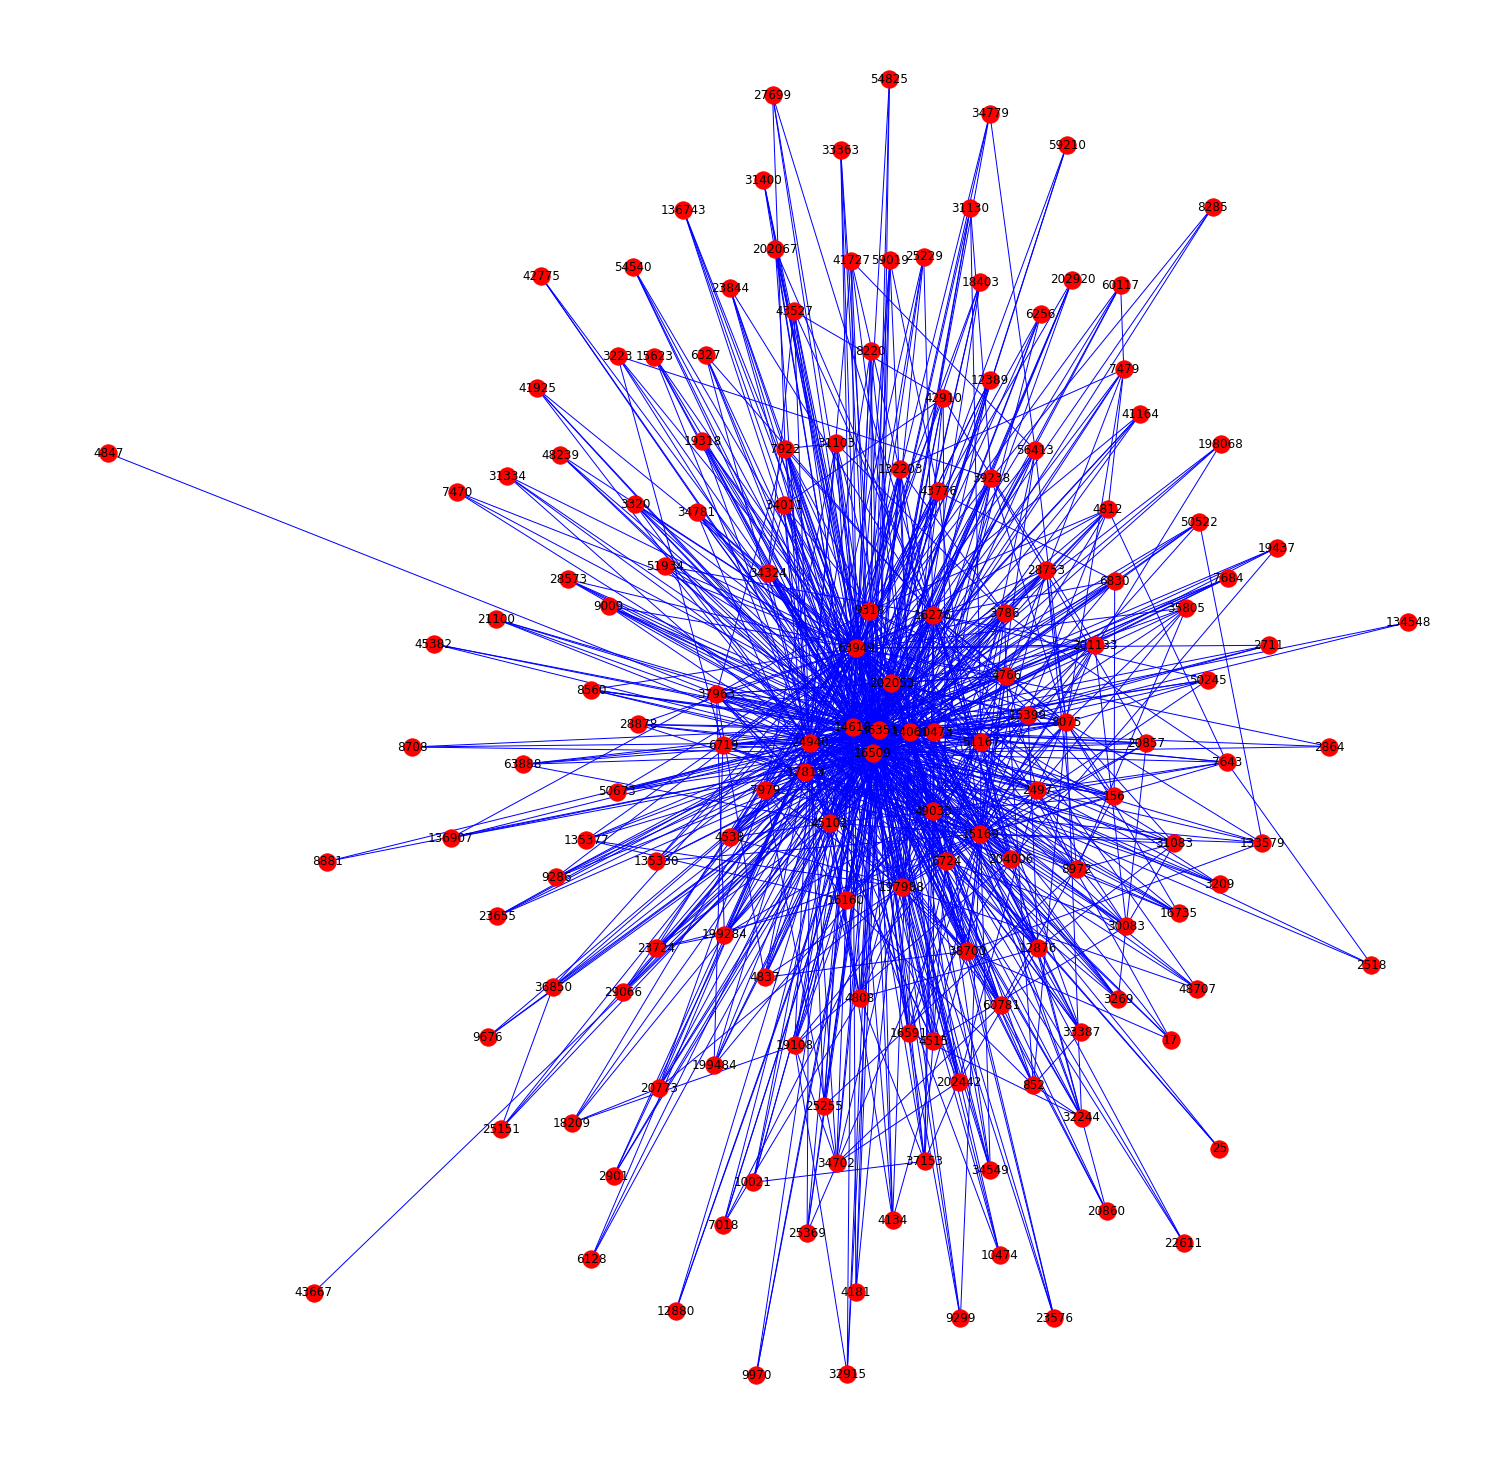

In [12]:
plt.figure(figsize=(20,20))
nx.draw(topo, with_labels = True, font_color='black', edge_color='blue')

## Plot graph on map

In [13]:
def generate_map(ases,edges):
    edges_position = set()
    for elem in edges:
        lat = ases[elem[0]]
        lon = ases[elem[1]]
        edges_position.add((lat,lon))
        
    # Make an empty map
    m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)

    # I can add marker one by one on the map
    for elem in ases.keys():
        folium.Marker(ases[elem], popup=elem).add_to(m)

    for elem in edges_position:
        folium.PolyLine(locations = elem, weight=1).add_to(m) 
    return m

In [15]:
generate_map(ases_ripple,edges)

In [16]:
print('Number of edges : {}'.format(len(edges)))

Number of edges : 1221


## Explore shortest path algorithm of NetworkX

## Compute shortest path for each tuple (source,target) and create Graph

In [17]:
shortest_graph = nx.Graph()
shortest_graph.add_nodes_from(ases_ripple)

In [18]:
max_path = -1
shortest_edges = set()
for source_targets in nx.all_pairs_shortest_path(topo, cutoff=10):
    source = source_targets[0]
    for target in source_targets[1].keys():
        route = source_targets[1][target]
        max_path = max(max_path,len(route))
        if (len(route) >= 2):
            for n in range(len(route)-1):
                s = route[n]
                t = route[n+1]
                if not (tuple([s,t]) in shortest_edges or tuple([t,s]) in shortest_edges):
                    shortest_edges.add(tuple([route[n], route[n+1]]))
                    
shortest_graph.add_edges_from(shortest_edges)
print('Longest path is {}'.format(max_path))

Longest path is 4


## Plot Graph

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


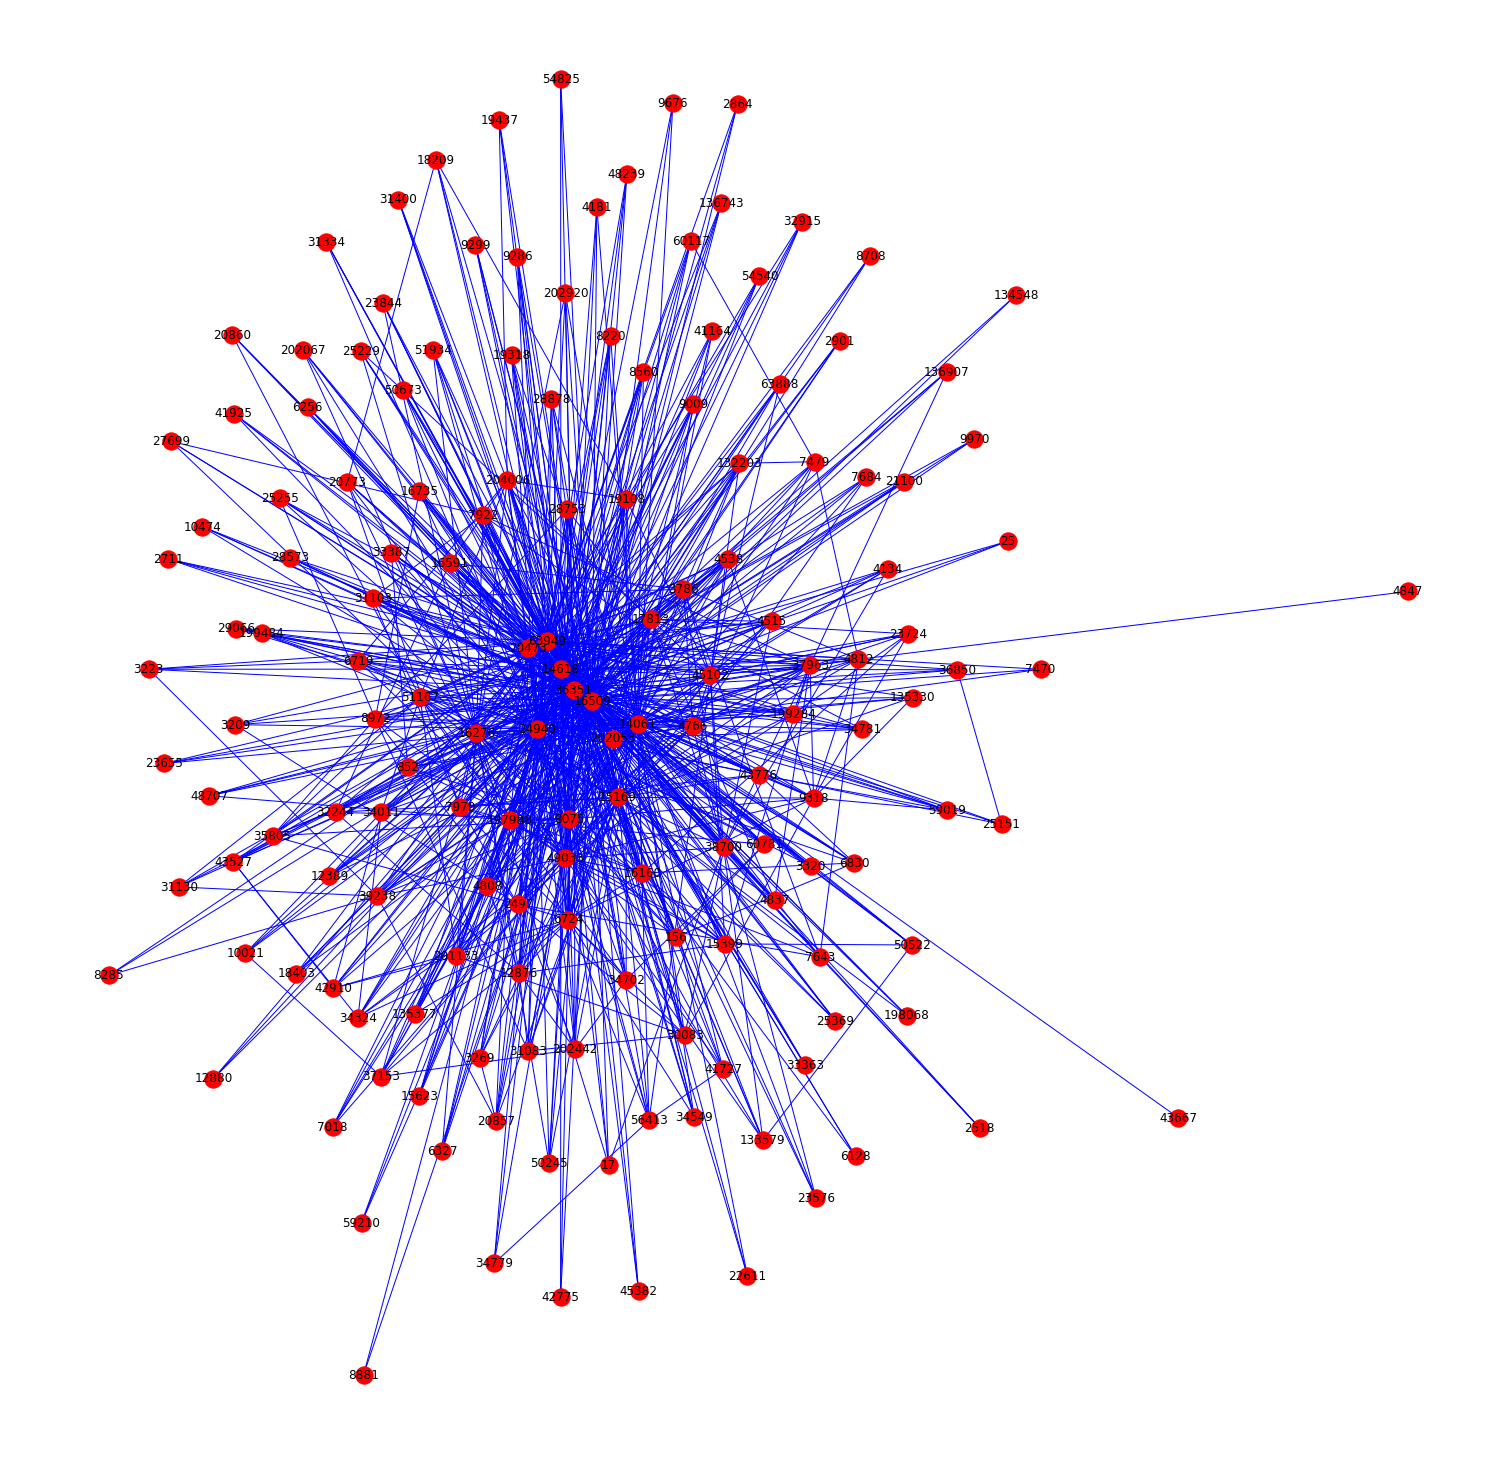

In [19]:
plt.figure(figsize=(20,20))
nx.draw(shortest_graph, with_labels = True, font_color='black', edge_color='blue')

## Plot graph on Map

In [21]:
generate_map(ases_ripple,shortest_edges)

Well, there is not so much difference. Do shortest paths function removes many edges?

In [22]:
print('Edges removed : {}'.format(len(edges)-len(shortest_edges)))
print('Number of edges : {}'.format(len(shortest_edges)))

Edges removed : 241
Number of edges : 980


## Compute shortest path following the paper 

http://www.cs.yale.edu/homes/schapira/BGPAttack.pdf

## Compute method to select best path (shortest + smallest ASN)

In [26]:
best_paths = []
for source in ases_ripple.keys():
    for target in ases_ripple.keys():
        if source != target:
            paths = np.array(list(nx.all_shortest_paths(topo,source,target)))
            if(len(paths) != 1):
                best_path = select_best(paths)
                best_paths.append(best_path)
            else:
                best_paths.append(paths[0])
len(best_paths)

24492

## Convert paths to edges

In [27]:
best_edges = set()
for route in best_paths:
    if (len(route) >= 2):
        for n in range(len(route)-1):
            s = route[n]
            t = route[n+1]
            if not (tuple([s,t]) in best_edges or tuple([t,s]) in best_edges):
                best_edges.add(tuple([route[n], route[n+1]]))

print('Edges removed : {}'.format(len(edges)-len(best_edges)))

Edges removed : 241


## Create Graph and plot it

In [29]:
best_graph = nx.Graph()
best_graph.add_nodes_from(ases_ripple)
best_graph.add_edges_from(best_edges)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


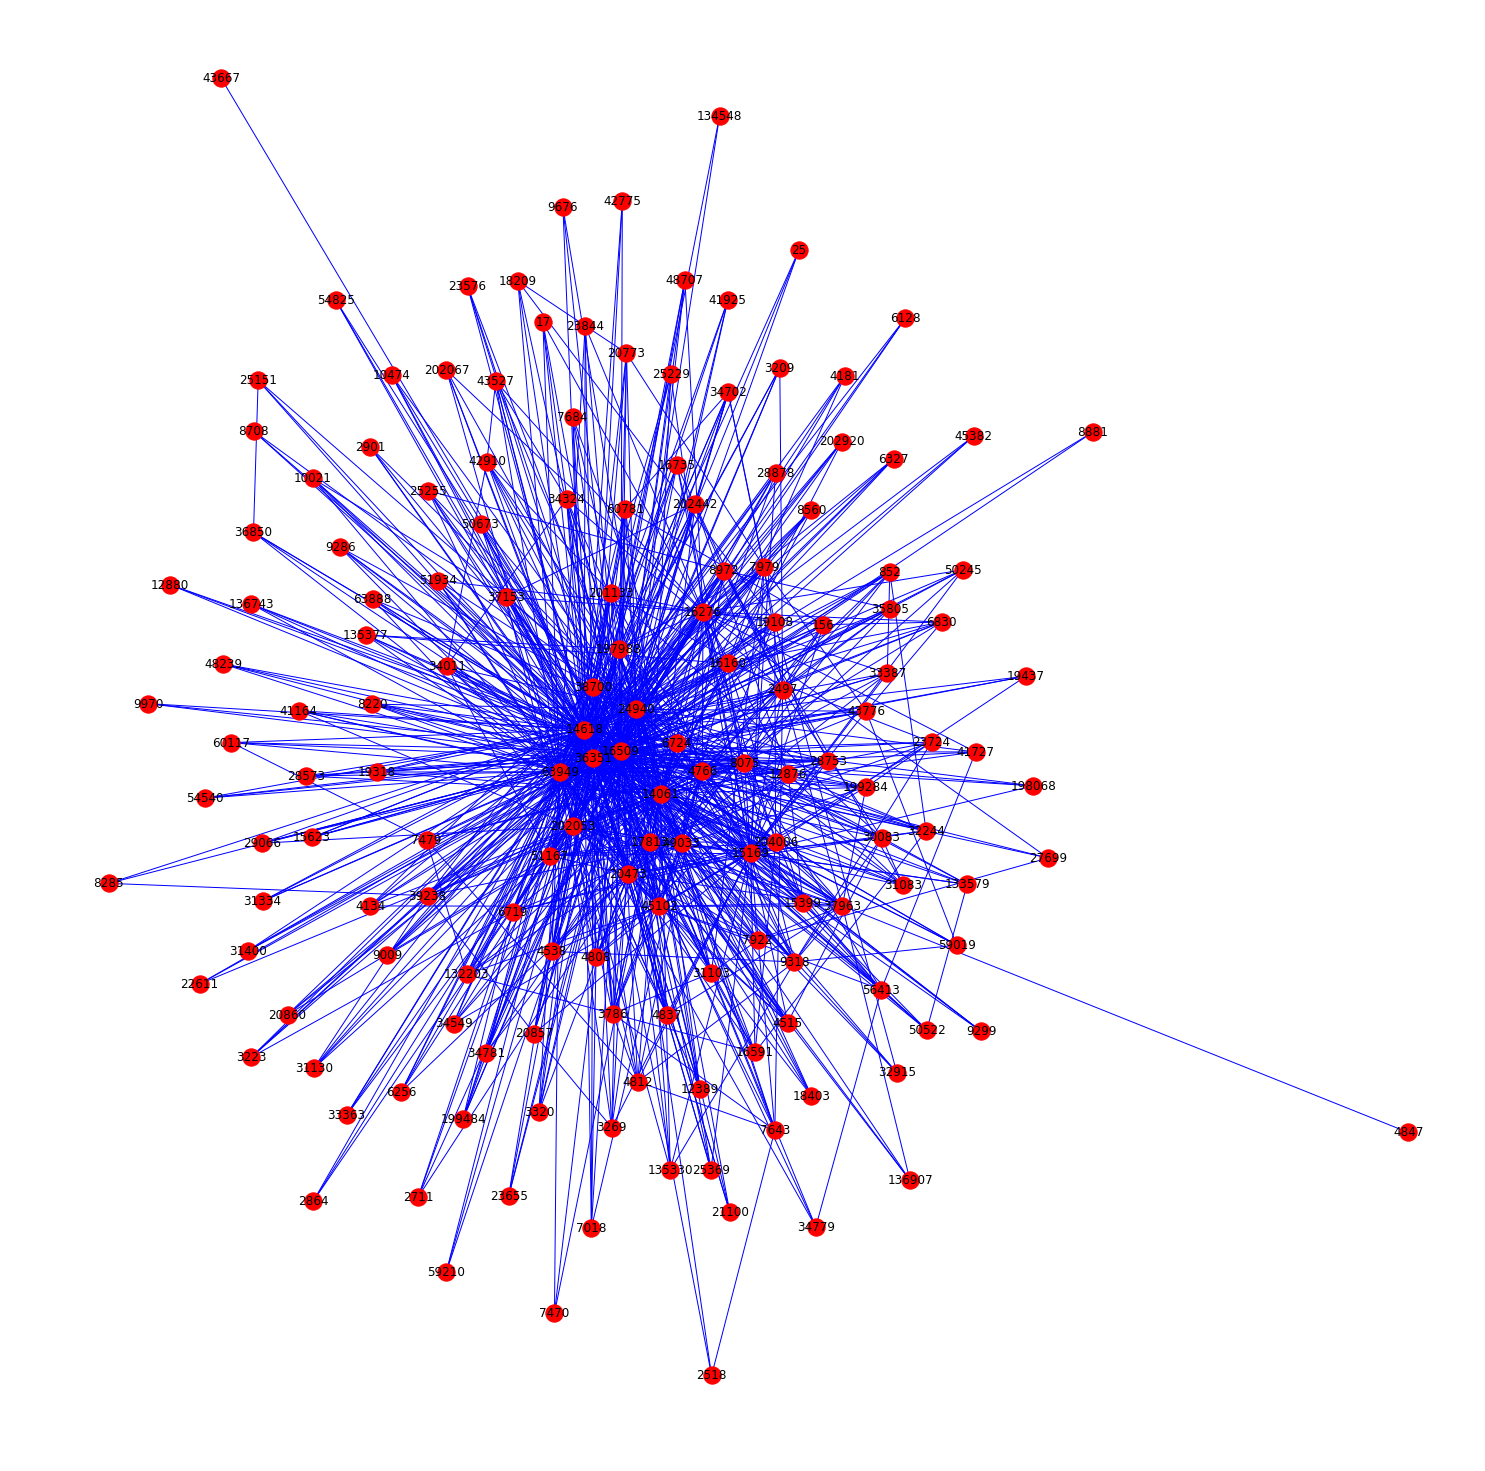

In [30]:
plt.figure(figsize=(20,20))
nx.draw(shortest_graph, with_labels = True, font_color='black', edge_color='blue')

In [31]:
generate_map(ases_ripple,best_edges)

In [32]:
print('Edges removed : {}'.format(len(edges)-len(best_edges)))
print('Number of edges : {}'.format(len(best_edges)))

Edges removed : 241
Number of edges : 980


## Analyze connectivity

Display how many nodes must be removed to disconnect the graph

In [33]:
nx.node_connectivity(best_graph)

1

I assume the most connected one can break the network

In [35]:
links_ripple.groupby('start').size().sort_values(ascending=False).index[0]

'16509'

In [36]:
links_ripple.groupby('end').size().sort_values(ascending=False).index[0]

'16509'

In [37]:
best_graph.remove_node('16509')

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


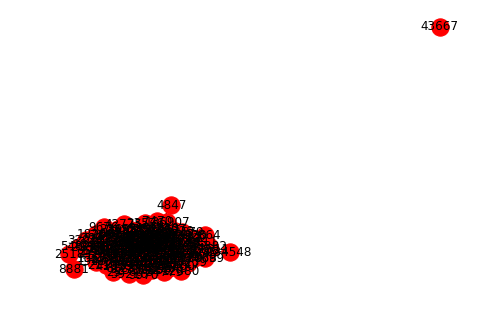

In [38]:
nx.draw(best_graph,with_labels=True)

If 16509 stop responding, 43667 is completly disconnected

Who is 16509? 
Country:  US
Registration Date:  2000-05-04
Registrar:  arin
Owner:  AMAZON-02 - Amazon.com, Inc., US

Who is 43667?
Country:  RU
Registration Date:  2007-09-10
Registrar:  ripencc
Owner:  VRMNT-AS, RU

